In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

lp_images_path = 'selection/'
lp_images = os.listdir(lp_images_path)
lp_aspect_ratio = 5 / 2
lp_width = 250

img = cv2.imread('selection/18838_0_7_21_29_30_32_10.jpg')
img = cv2.resize(img, (lp_width, int(lp_width / lp_aspect_ratio)))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [2]:
def get_thresholded(img):
    img_height, img_width, _ = img.shape
    gray = img.copy()
    gray = cv2.cvtColor(gray, cv2.COLOR_BGR2GRAY)

    rectKern = cv2.getStructuringElement(cv2.MORPH_RECT, (img_width, img_height))
    black_hat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, rectKern)
    close = cv2.morphologyEx(black_hat, cv2.MORPH_CLOSE, kernel= np.ones((3,3), np.uint8), iterations=2)

    thresh = cv2.threshold(close, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]/255
    
    return thresh

In [3]:
def normalize_array(arr):
    min_val = np.min(arr)
    max_val = np.max(arr)
    normalized_arr = ((arr - min_val) / (max_val - min_val)) * 100
    return normalized_arr

In [4]:
def get_separators_from_sequence(sequence):
    separator_indices = []
    if len(sequence) > 5:
        separator_indices.append(sequence[2])
        separator_indices.append(sequence[-3])
    else:
        separator_indices.append(sequence[len(sequence) // 2])
    return separator_indices

def get_separators(arr):
    separator_indices = []

    current_sequence = [arr[0]]
    for i in range(1, len(arr)):
        if arr[i] == arr[i - 1] + 1:
            current_sequence.append(arr[i])
        else:
            separator_indices.extend(get_separators_from_sequence(current_sequence))
            current_sequence = [arr[i]]
    
    separator_indices.extend(get_separators_from_sequence(current_sequence))
    
    return separator_indices

def split_lp(image, separator_indices):    
    letters = []

    start = 0
    for letter_idx in range(len(separator_indices)):
        end = separator_indices[letter_idx]
        if end - start > 20:
            letters.append(image[:, start:end])
        start = separator_indices[letter_idx]
        
    return letters

In [5]:
thresh = get_thresholded(img)

# Get vertical histogram
vertical_hist = -np.sum(thresh, axis=0)
vertical_hist = normalize_array(vertical_hist)
segmentation_threshold = 10

# Over segmentation
bars = np.where(vertical_hist < segmentation_threshold)[0]
over_segmented = thresh.copy()
over_segmented[:, bars] = 0

# Proper segmentation
separator_indices = get_separators(bars)
segmented = thresh.copy()
segmented[:, separator_indices] = 0

# Split into letters
letters = split_lp(img, separator_indices)

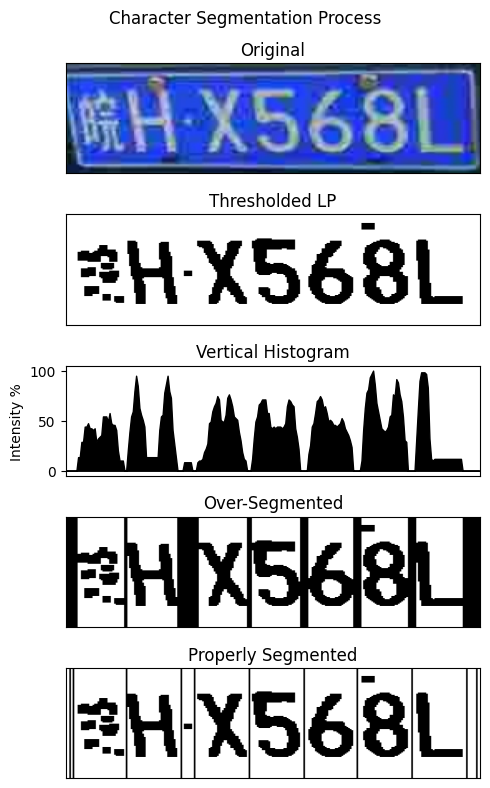

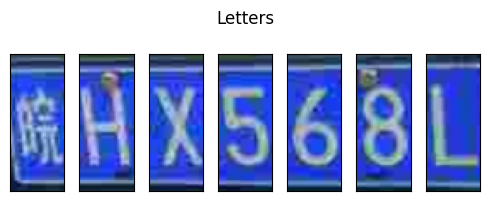

In [6]:
# Plot the results
fig, axs = plt.subplots(5, 1, sharex=True, figsize=(5, 8))
fig.suptitle('Character Segmentation Process')

axs[0].imshow(img, cmap='gray', aspect='auto')
axs[0].set_title('Original')
axs[0].yaxis.set_ticks([])
axs[0].xaxis.set_ticks([])

axs[1].imshow(thresh, cmap='gray', aspect='auto') 
axs[1].set_title('Thresholded LP')
axs[1].yaxis.set_ticks([])
axs[1].xaxis.set_ticks([])

axs[2].fill_between(range(len(vertical_hist)),vertical_hist, 0, color='black')
axs[2].set_title('Vertical Histogram')
axs[2].set_ylabel('Intensity %')

axs[3].imshow(over_segmented, cmap='gray', aspect='auto')
axs[3].set_title('Over-Segmented')
axs[3].yaxis.set_ticks([])
axs[3].xaxis.set_ticks([])

axs[4].imshow(segmented, cmap='gray', aspect='auto')
axs[4].set_title('Properly Segmented')
axs[4].yaxis.set_ticks([])
axs[4].xaxis.set_ticks([])

plt.tight_layout()
plt.show()

# Plot the letters
fig, axs = plt.subplots(1, len(letters), sharey=True, figsize=(5, 2))
fig.suptitle('Letters')

for i, letter in enumerate(letters):
    axs[i].imshow(letter, aspect='auto')
    axs[i].yaxis.set_ticks([])
    axs[i].xaxis.set_ticks([])

plt.tight_layout()
plt.show()

# Simplified Splitting

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact

def get_lp_split(img_threshold, img, intensity_threshold, min_width, padding):
    letters = []
    start_index = -1

    def add_letter(start, end):
        start = max(start - padding, 0)
        end = min(end + padding, img_threshold.shape[1])
        letters.append(img[:, start:end])

    for column in range(img_threshold.shape[1]):
        if 100 - np.sum(img_threshold[:, column]) > intensity_threshold:
            if start_index == -1:
                start_index = column
        else:
            if start_index != -1 and column - start_index > min_width:
                add_letter(start_index, column)
                start_index = -1

    if start_index != -1:
        add_letter(start_index, img_threshold.shape[1])

    return letters

# Plotting 

In [14]:
def plot_lp_split(img, thresh):
    # sliders for thresholds
    @interact(intensity_threshold=(0, 100, 1), min_width=(0, 50, 1), padding=(0, 10, 1))

    def update_sliders(intensity_threshold=5, min_width=0, padding=5):
        letters = get_lp_split(thresh, img, intensity_threshold, min_width, padding)

        if len(letters) == 0:
            letters = [img]

        # plot letters
        fig, axs = plt.subplots(1, len(letters), sharey=True, figsize=(5, 2))
        fig.suptitle('Letters')
        
        if len(letters) == 1:
            axs = [axs]

        for i, letter in enumerate(letters):
            axs[i].imshow(letter, aspect='auto')
            axs[i].yaxis.set_ticks([])
            axs[i].xaxis.set_ticks([])

        plt.tight_layout()
        plt.show()

    plt.show()

In [13]:
thresh = get_thresholded(img)
plot_lp_split(img, thresh)

interactive(children=(IntSlider(value=5, description='intensity_threshold'), IntSlider(value=0, description='m…